In [15]:
import os
import hydra
import torch
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from src.module import AerialModule
from src.processing_utils import color_code_mask1

os.chdir('/home/gptrapletti/ds/aerial-multiclass-segm')

In [2]:
BEST_CKPT_PATH = 'logs/hydra/aerial-multiclass-segm/2023-12-30_18-44-06_patch:256_loss:dice_backbone:default/checkpoints/epoch=31.ckpt'
DEVICE = 'cuda:0'

# # Dummy, with save_hyperparameters(ignore=[...])
# BEST_CKPT_PATH = 'logs/hydra/aerial-multiclass-segm/2024-01-20_12-26-36_test/checkpoints/epoch=1.ckpt'

In [3]:
with hydra.initialize(version_base=None, config_path='../configs'):
    cfg = hydra.compose(config_name='config.yaml')
    
# print(OmegaConf.to_yaml(cfg))
# print(cfg)

In [4]:
datamodule = hydra.utils.instantiate(cfg.datamodule)

In [5]:
module = AerialModule.load_from_checkpoint(BEST_CKPT_PATH)
module = module.eval()
module = module.to(DEVICE)

/home/gptrapletti/ds/.miniconda/envs/aerial/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gptrapletti/ds/.miniconda/envs/aerial/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/gptrapletti/ds/.miniconda/envs/aerial/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
/home/gptrapletti/ds/.miniconda/envs/aerial/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute '

In [6]:
datamodule.prepare_data()
datamodule.setup('fit')
ds = datamodule.val_dataset
dl = datamodule.val_dataloader()

In [7]:
idx = 0
ds[idx][0].shape, ds[idx][1].shape

(torch.Size([3, 256, 256]), torch.Size([6, 256, 256]))

In [8]:
images, gts, _ = next(iter(dl))
images.shape, gts.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 6, 256, 256]))

In [9]:
images = images.to(DEVICE)
logits = module(images)
logits.shape

torch.Size([32, 6, 256, 256])

In [10]:
softmax = torch.nn.Softmax(dim=1)

In [11]:
logits = logits.detach().cpu()
preds = softmax(logits)
preds = torch.where(preds > 0.5, 1., 0.)
preds.shape

torch.Size([32, 6, 256, 256])

In [12]:
torch.sum(gts, dim=[2, 3]) > 0

tensor([[ True,  True, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True, False, False, False, False],
        [ True,  True, False,  True, False, False],
        [ True,  True,  True,  True, False, False],
        [ True,  True,  True, False,  True, False],
        [ True,  True, False, False,  True, False],
        [ True, False, False, False,  True, False],
        [ True, False, False, False,  True, False],
        [ True,  True, False,  True,  True, False],
        [ True,  True, False,  True,  True, False],
        [ True,  True, False, False, False,  True],
        [False,  True, False, False, False,  True],
        [ True,  True, False, False, False,  True],
        [ True,  True, False, False, False, False],
        [False,  True,  True,  True, False, False],
        [False,  True,  True,  True, False, False],
        [False,  True,  True, False,  True, False],
        [Fal

In [13]:
# i = 5
# c = 2

i = 25
c = 5

pred = preds[i]
gt = gts[i]

# i: 5, class: 2
# i: 25, class: 5

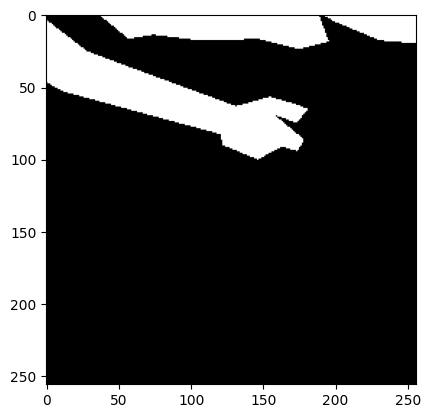

In [25]:
plt.imshow(gt[c, ...].numpy() * 255, cmap='gray')
plt.show()

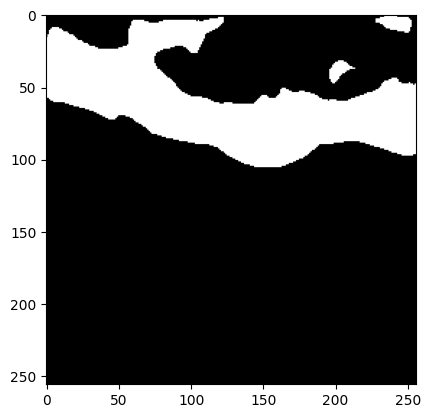

In [ ]:
plt.imshow(pred[c, ...].numpy() * 255, cmap='gray')
plt.show()

In [ ]:
len(ds.patch_bboxs)

9600

In [ ]:
ds.patch_bboxs[i]

('007.jpg', ((512, 256), (768, 512)))

In [ ]:
photo = cv2.imread(os.path.join('/home/gptrapletti/ds/aerial-multiclass-segm/data/images', ds.patch_bboxs[i][0]))
photo = cv2.cvtColor(photo, cv2.COLOR_BGR2RGB)
photo.shape

(2000, 3000, 3)

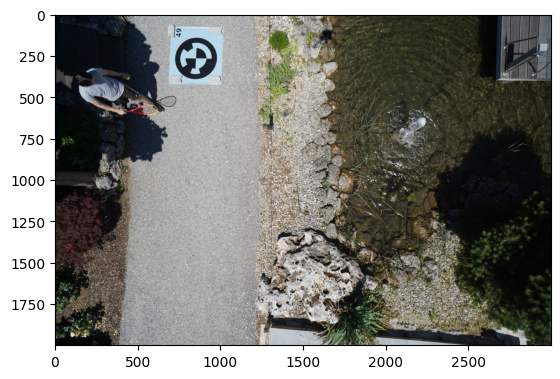

In [ ]:
# plt.figure(figsize=(15, 15))
plt.imshow(photo)
plt.show()

In [ ]:
filename = os.path.splitext(ds.patch_bboxs[i][0])[0] + '.png'
mask = cv2.imread(os.path.join('/home/gptrapletti/ds/aerial-multiclass-segm/data/masks', filename))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
mask.shape

(2000, 3000, 3)

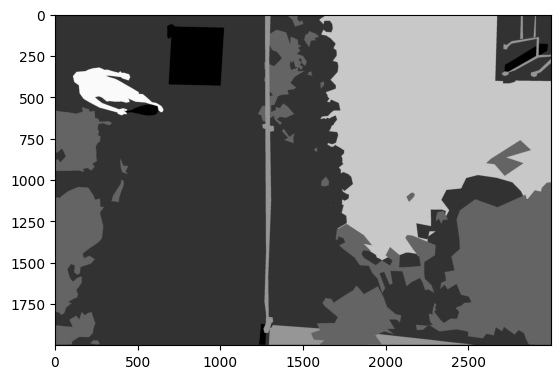

In [ ]:
plt.imshow(mask * 50)
plt.show()

In [ ]:
# TODO: 
# - Understand how to visualize aerial image
# - visualize entire aerial photo, its entire mask colored, than patch level

In [ ]:
color_coded_mask = color_code_mask(mask)

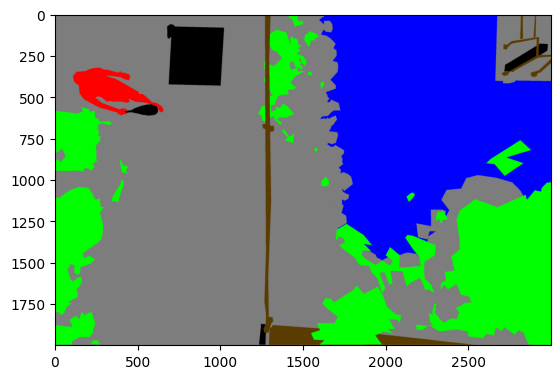

In [ ]:
plt.imshow(color_coded_mask)
plt.show()

In [ ]:
# Assemble predicted patches in whole images

In [ ]:
len(ds.mask_filepaths), len(ds.patch_bboxs)

(100, 9600)

In [ ]:
ds.mask_filepaths[0], ds.patch_bboxs[0]

('/home/gptrapletti/ds/aerial-multiclass-segm/data/masks/007.png',
 ('007.jpg', ((0, 0), (256, 256))))

In [ ]:
ds.mask_filepaths[-1], ds.patch_bboxs[-1]

('/home/gptrapletti/ds/aerial-multiclass-segm/data/masks/400.png',
 ('400.jpg', ((1744, 2744), (2000, 3000))))

In [ ]:
# OPZIONE 1
# - cicla su tutto il dataloader e metti tutte le predizioni in una lista
# - cons: spazio!

# OPZIONE 2
# - procedere per batch
# - a inizio batch inizializzare tensore vuoto
# - predizione sul batch
# - inserisci pattch by patch nel tensore vuoto

In [ ]:
preds.shape

torch.Size([32, 6, 256, 256])

In [ ]:
# From preds (6 channels, each one binary) to color coded predictions
v = torch.tensor([0, 1, 2, 3, 4, 5])
v = v.reshape(shape=[1, 6, 1, 1])
v.shape

torch.Size([1, 6, 1, 1])

In [ ]:
preds2 = preds * v # [32, 6, 256, 256]
preds3 = torch.sum(preds2, dim=1) # [32, 256, 256]
preds3.shape

torch.Size([32, 256, 256])

In [ ]:
preds4 = torch.concat((preds3.unsqueeze(-1), preds3.unsqueeze(-1), preds3.unsqueeze(-1)), dim=-1) # [32, 256, 256, 3]

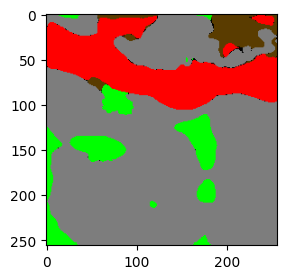

In [34]:
p = color_code_mask(preds4[25].numpy().astype(np.int64))

plt.figure(figsize=(3, 3))
plt.imshow(p)
plt.show()

In [35]:
# better to proceed by dataloader

In [36]:
len(dl.dataset.patch_bboxs)

9600

In [37]:
dl.batch_size

32

In [38]:
# i*bs, (i+1)*bs
# 0: 0, 32
# 1: 32, 64
# 2: 64, 96

In [33]:
# del logits

In [16]:
softmax = torch.nn.Softmax(dim=1)
current_image_filename = None
current_image = np.zeros(shape=(2000, 3000, 3))
image_ls = []

# for i, batch in tqdm(enumerate(dl), total=len(dl)):
for i, batch in enumerate(dl):
    # print(i)
    images, gts, _ = batch
    batch_patch_bboxs = dl.dataset.patch_bboxs[i*dl.batch_size : (i+1)*dl.batch_size]
    
    # Prediction
    images = images.to(DEVICE)
    logits = module(images) # [32, 6, 256, 256]
    logits = logits.detach().cpu()
    # Probs
    preds = softmax(logits) # [32, 6, 256, 256]
    # Category IDs for the category with higher prob
    preds = torch.argmax(preds, dim=1) # [32, 256, 256]
        
    # # From preds (6 channels, each one binary) to color coded predictions
    # v = torch.tensor([0, 1, 2, 3, 4, 5])
    # v = v.reshape(shape=[1, 6, 1, 1])
    
    # Set first current image
    if current_image_filename is None:
        current_image_filename = batch_patch_bboxs[0][0]
           
    # v2
    for j, (pred_patch, patch_bbox) in enumerate(zip(preds, batch_patch_bboxs)):
        # print('\t', j)
        image_filename, bbox = patch_bbox
        print(patch_bbox)
        # pred_patch shape = [256, 256]
        pred_patch = torch.concat((pred_patch.unsqueeze(-1), pred_patch.unsqueeze(-1), pred_patch.unsqueeze(-1)), axis=-1) # [256, 256, 3]
        color_coded_patch = color_code_mask1(pred_patch.numpy())        
        cv2.imwrite( # TODO: remove
                filename='/home/gptrapletti/ds/aerial-multiclass-segm/temp.jpg', 
                img=color_coded_patch.astype(np.uint8)
            )
        
        if current_image_filename == image_filename:
            current_image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :] = color_coded_patch
        else:
            # image_ls.append(current_image)
            # Save image
            current_image = cv2.cvtColor(current_image.astype(np.uint8), cv2.COLOR_RGB2BGR)
            cv2.imwrite(filename=os.path.join('temp', current_image_filename), img=current_image)            
            
            current_image_filename = image_filename
            current_image = np.zeros(shape=(2000, 3000, 3))
            current_image[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1], :] = color_coded_patch

('007.jpg', ((0, 0), (256, 256)))
('007.jpg', ((0, 256), (256, 512)))
('007.jpg', ((0, 512), (256, 768)))
('007.jpg', ((0, 768), (256, 1024)))
('007.jpg', ((0, 1024), (256, 1280)))
('007.jpg', ((0, 1280), (256, 1536)))
('007.jpg', ((0, 1536), (256, 1792)))
('007.jpg', ((0, 1792), (256, 2048)))
('007.jpg', ((0, 2048), (256, 2304)))
('007.jpg', ((0, 2304), (256, 2560)))
('007.jpg', ((0, 2560), (256, 2816)))
('007.jpg', ((0, 2744), (256, 3000)))
('007.jpg', ((256, 0), (512, 256)))
('007.jpg', ((256, 256), (512, 512)))
('007.jpg', ((256, 512), (512, 768)))
('007.jpg', ((256, 768), (512, 1024)))
('007.jpg', ((256, 1024), (512, 1280)))
('007.jpg', ((256, 1280), (512, 1536)))
('007.jpg', ((256, 1536), (512, 1792)))
('007.jpg', ((256, 1792), (512, 2048)))
('007.jpg', ((256, 2048), (512, 2304)))
('007.jpg', ((256, 2304), (512, 2560)))
('007.jpg', ((256, 2560), (512, 2816)))
('007.jpg', ((256, 2744), (512, 3000)))
('007.jpg', ((512, 0), (768, 256)))
('007.jpg', ((512, 256), (768, 512)))
('007.jp

KeyboardInterrupt: 

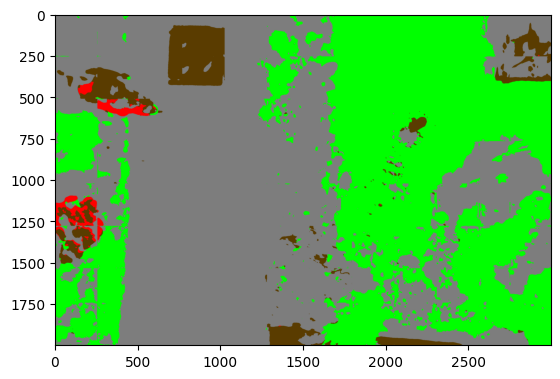

In [40]:
plt.imshow(current_image.astype(np.uint8))
plt.show()

In [9]:
a = np.random.randint(low=0, high=6, size=(5, 5))
b = np.stack([a, a, a], axis=2)
b.shape

(5, 5, 3)

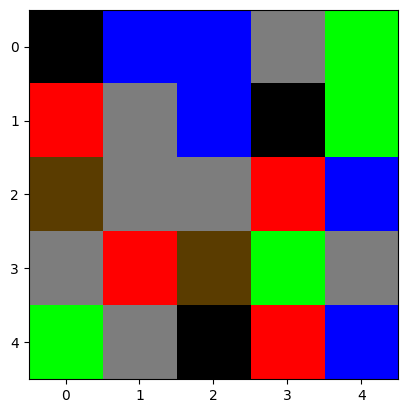

In [10]:
plt.imshow(color_code_mask1(b))